# Churn_Modelling
#### Reference: https://www.kaggle.com/aakash50897/churn-modellingcsv

In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing dataset
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values
dataset[0:10]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


## Data Preprocessing

In [2]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Fitting the classifier to the Training set: CatBoost

In [3]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier(iterations = 100, learning_rate = 1, verbose = 0)
classifier.fit(X_train, y_train)

## Making the Confusion Matrix

In [4]:
from sklearn.metrics import confusion_matrix 
def Classification(clf, X, y):
    X_set, y_set = X, y
    y_hat = clf.predict(X_set)
    y_hat = np.reshape(y_hat, -1)
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0
    cm = confusion_matrix(y_set, y_hat)    
    TN = cm[0, 0]
    FN = cm[1, 0]
    TP = cm[1, 1]
    FP = cm[0, 1]    
    accuracy = (TP + TN)/(TN + FN + TP + FP)
    PPV = TP/(TP + FP) # Positive Predictive Value, Precision 
    TPR = TP/(TP + FN) # Sensitivitive, Recall    
    TNR = TN/(TN + FP) # Specificitive
    NPV = TN/(TN + FP) # Negative Predictive Value    
    F1_score = 2/(1/PPV + 1/TPR)
    summary = {'Accuracy': accuracy, 
               'Positive_Predictive_Value': PPV, 
               'Negative_Predictive_Value': NPV,            
               'Sensitivitive': TPR, 
               'Specificitive': TNR,            
               'F1_score': F1_score, 
               'CM': cm}
    return summary

### Training Set

In [5]:
Classification(clf = classifier, X = X_train, y = y_train)

{'Accuracy': 0.928125,
 'Positive_Predictive_Value': 0.9217877094972067,
 'Negative_Predictive_Value': 0.9846105527638191,
 'Sensitivitive': 0.7077205882352942,
 'Specificitive': 0.9846105527638191,
 'F1_score': 0.8006932409012131,
 'CM': array([[6270,   98],
        [ 477, 1155]], dtype=int64)}

### Test Set

In [6]:
Classification(clf = classifier, X = X_test, y = y_test)

{'Accuracy': 0.846,
 'Positive_Predictive_Value': 0.6439169139465876,
 'Negative_Predictive_Value': 0.9247648902821317,
 'Sensitivitive': 0.5358024691358024,
 'Specificitive': 0.9247648902821317,
 'F1_score': 0.5849056603773585,
 'CM': array([[1475,  120],
        [ 188,  217]], dtype=int64)}

## Using k-fold Cross Validation to evaluate the model's performance
https://www.kaggle.com/miklgr500/catboost-with-gridsearch-cv

In [7]:
# Applying k-fold Cross Validation
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
def cross_val(clf, X, y, n_splits = 5, plot_result = True):
    kf = KFold(n_splits = n_splits)
    scores = []
    for train_ind, val_ind in kf.split(X, y):
        X_train = X[train_ind]
        y_train = y[train_ind]        
        X_valid = X[val_ind]
        y_valid = y[val_ind]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_valid)        
        score = f1_score(y_valid, y_pred)
        scores.append(score)
    scores = np.array(scores) 
    if(plot_result):
        plt.plot(scores, '-o')
        plt.axhline(scores.mean(), color = 'black', ls = '-')
        plt.axhline(scores.mean() + 2 * scores.std(), color = 'black', ls = '--')
        plt.axhline(scores.mean() - 2 * scores.std(), color = 'black', ls = '--')
        plt.xlabel('CV')
        plt.ylabel('F1 score')
        plt.title('Classifier: ' + clf.__class__.__name__)
        plt.show()   
        print(clf.__class__.__name__ + ' CV score = %0.3f (+/- %0.3f)' % (scores.mean(), 2 * scores.std()))
    return scores   

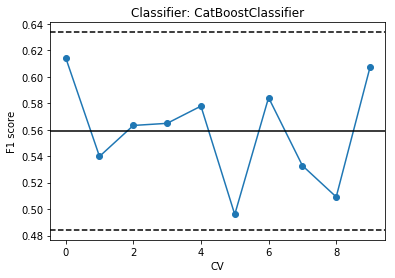

CatBoostClassifier CV score = 0.559 (+/- 0.075)


In [8]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier(iterations = 100, learning_rate = 1, verbose = 0)
scores = cross_val(clf = classifier, X = X_train, y = y_train, n_splits = 10)

# Conclusion
此二元分類問題採用的是 CatBoostClassifier 作為分類器，並以 k-fold Cross Validation 來評估模型的表現。